In [1]:
import numpy as np
import pandas as pd
import re
import json
import glob
from PIL import Image

#import warnings
#warnings.filterwarnings('ignore')

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import *
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold, StratifiedKFold

from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import xgboost as xgb
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin

#https://www.kaggle.com/sudalairajkumar/getting-started-with-h2o
#import h2o
#h2o.init()

import os
print(os.listdir("../input"))

from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.metrics import cohen_kappa_score, make_scorer
import lightgbm as lgb

# import fastai.vision as fv
# from fastai import version
# from fastai.torch_core import *
# from fastai.vision.image import *
# from fastai.vision.transform import *
# from fastai.data_block import *
# from fastai.basic_data import *
# from fastai.layers import *
# from fastai.vision.learner import *
# from torchvision import transforms as tvt

# __all__ = ['get_image_files', 'denormalize', 'get_annotations', 'ImageDataBunch',
#            'ImageList', 'normalize', 'normalize_funcs', 'resize_to',
#            'channel_view', 'mnist_stats', 'cifar_stats', 'imagenet_stats', 'download_images',
#            'verify_images', 'bb_pad_collate', 'ImageImageList', 'PointsLabelList',
#            'ObjectCategoryList', 'ObjectItemList', 'SegmentationLabelList', 'SegmentationItemList', 'PointsItemList']
# print("fastai version is {}".format(version.__version__))


['intermediate-data', 'test-features-from-images', 'features-from-images', 'petfinder-adoption-prediction', 'test-fetures-from-resnet101']


Downloading datasets

In [2]:
PATH = '../input/petfinder-adoption-prediction/'

train = pd.read_csv(PATH+'train/train.csv')
test = pd.read_csv(PATH+'test/test.csv')
sample_submission = pd.read_csv(PATH+'test/sample_submission.csv')

In [3]:
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [4]:
test.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt
0,1,Puppy,2,307,0,1,1,0,0,2,2,2,2,2,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,"Puppy is calm for a young dog, but he becomes ...",378fcc4fc,3.0
1,2,London,24,266,0,1,2,7,0,2,1,1,1,1,1,1,0,41326,4475f31553f0170229455e3c5645644f,0,Urgently seeking adoption. Please contact for ...,73c10e136,1.0
2,2,Snowball,20,266,0,2,7,0,0,2,1,1,1,1,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,Snowball... doesn't look so good (she is healt...,72000c4c5,1.0
3,2,Malibu,5,266,252,2,1,6,7,2,1,1,1,1,1,1,100,41326,4475f31553f0170229455e3c5645644f,0,"Malibu: Female, Local Mix, 4-5 months, vaccina...",e147a4b9f,1.0
4,1,Lala Girl,6,307,0,2,1,2,7,2,1,1,1,1,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,LALA! That's my name. I'm a 6 month old girl d...,43fbba852,1.0


We see that most of information is categorical, but alreasy encoded, the description for some we can find in these files:

In [5]:
labels_breed = pd.read_csv(PATH+'breed_labels.csv', index_col='BreedID')
labels_state = pd.read_csv(PATH+'state_labels.csv', index_col='StateID')
labels_color = pd.read_csv(PATH+'color_labels.csv', index_col='ColorID')

# Table dataset processing

Let's take a look at information:

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3948 entries, 0 to 3947
Data columns (total 23 columns):
Type            3948 non-null int64
Name            3645 non-null object
Age             3948 non-null int64
Breed1          3948 non-null int64
Breed2          3948 non-null int64
Gender          3948 non-null int64
Color1          3948 non-null int64
Color2          3948 non-null int64
Color3          3948 non-null int64
MaturitySize    3948 non-null int64
FurLength       3948 non-null int64
Vaccinated      3948 non-null int64
Dewormed        3948 non-null int64
Sterilized      3948 non-null int64
Health          3948 non-null int64
Quantity        3948 non-null int64
Fee             3948 non-null int64
State           3948 non-null int64
RescuerID       3948 non-null object
VideoAmt        3948 non-null int64
Description     3946 non-null object
PetID           3948 non-null object
PhotoAmt        3948 non-null float64
dtypes: float64(1), int64(18), object(4)
memory usage: 709.

In [8]:
no_name_train = int(np.sum(train.Name.isna())/len(train.Name) * 100)
no_name_test = int(np.sum(test.Name.isna())/len(test.Name) * 100)
print(f'{no_name_train}% of train and {no_name_test}% of test names are missing')

8% of train and 7% of test names are missing


We can use PetIDs as index to simplify merging of datasets:

In [9]:
train.set_index('PetID', inplace=True)
test.set_index('PetID', inplace=True)

In [10]:
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,1.0,2
6296e909a,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,2.0,0
3422e4906,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,7.0,3
5842f1ff5,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",8.0,2
850a43f90,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,3.0,2


In addition to this dataset we have two more json files with processed images and descriptions. Let's merge them together. Fow this we need to do some additional procedures.

In [11]:
pd.DataFrame(index=['lll']).add_prefix('sentences_score_')

""
lll


In [12]:
class PetFinderParser(object):
    
    def __init__(self, debug=False):
        self.debug = debug
        self.sentence_sep = ' '
        self.extract_sentiment_text = False
    
    def open_metadata_file(self, filename):
        with open(filename, 'r') as f:
            metadata_file = json.load(f)
        return metadata_file
            
    def open_sentiment_file(self, filename):
        with open(filename, 'r') as f:
            sentiment_file = json.load(f)
        return sentiment_file
        
    def parse_sentiment_file(self, file, pet_id):        
        file_sentiment = file['documentSentiment']
        file_sentiment = pd.DataFrame(file_sentiment,  index=[pet_id]).add_prefix('document_')

        file_sentences_sentiment = pd.DataFrame.from_records(x['sentiment'] for x in file['sentences']).describe()
        file_sentences_magnitude = pd.DataFrame(file_sentences_sentiment.to_dict()['magnitude'], index=[pet_id]).add_prefix('sentences_magnitude_')
        file_sentences_score = pd.DataFrame(file_sentences_sentiment.to_dict()['score'], index=[pet_id]).add_prefix('sentences_score_')

        file_entities_type = dict(Counter([x['type'] for x in file['entities']]))
        file_entities_type = pd.DataFrame(file_entities_type, index=[pet_id])
        df_sentiment = pd.concat([file_sentiment,file_sentences_magnitude, file_sentences_score,file_entities_type], axis=1)
        return df_sentiment
    
    def parse_metadata_file(self, file, pet_id):
        file_keys = list(file.keys())
        if 'labelAnnotations' in file_keys:
            file_annots = pd.DataFrame.from_records(x for x in file['labelAnnotations'])
            file_top_desc = ''.join(file_annots['description'].iloc[:3].to_list())
            file_annots = file_annots.describe()
            file_annots_score = pd.DataFrame(file_annots.to_dict()['score'], index=[pet_id]).add_prefix('annots_score_')
            file_annots_topicality = pd.DataFrame(file_annots.to_dict()['topicality'], index=[pet_id]).add_prefix('annots_topicality_')
        else:
            file_annots_score = pd.DataFrame(index=[pet_id])
            file_annots_topicality = pd.DataFrame(index=[pet_id])
            file_top_desc = ''

        file_crops = file['cropHintsAnnotation']['cropHints']
        if 'importanceFraction' in file_crops[0].keys():
            file_crop_conf = np.array([x['confidence'] for x in file_crops]).mean()
        else:
            file_crop_conf = np.nan

        if 'importanceFraction' in file_crops[0].keys():
            file_crop_importance = np.array([x['importanceFraction'] for x in file_crops]).mean()
        else:
            file_crop_importance = np.nan

        df_metadata = {
            'top_decription': file_top_desc,
            'crop_conf_mean': file_crop_conf,
            'crop_importance': file_crop_importance,
        }

        df_metadata = pd.DataFrame(df_metadata, index=[pet_id])
        for i in range(2):
            file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors'][i]
            file_color_rgb = pd.DataFrame(file_colors['color'], index=[pet_id]).add_suffix(f'_{i}')
            del file_colors['color']
            file_color_score = pd.DataFrame(file_colors, index=[pet_id]).add_suffix(f'_{i}')
            df_metadata = pd.concat([df_metadata, file_color_rgb, file_color_score], axis=1)
        df_metadata = pd.concat([df_metadata,file_annots_score,file_annots_topicality], axis=1)
        df_metadata = df_metadata.add_prefix('metadata_')
        
        return df_metadata
    
def extract_additional_features(pet_id, mode='train'):
    sentiment_filename = 'input/{}_sentiment/{}.json'.format(mode, pet_id)
    try:
        sentiment_file = pet_parser.open_sentiment_file(sentiment_filename)
        df_sentiment = pet_parser.parse_sentiment_file(sentiment_file, pet_id)
    except FileNotFoundError:
        df_sentiment = pd.DataFrame()

    df_metadata = pd.DataFrame()
    metadata_filenames = sorted(glob.glob('input/{}_metadata/{}*.json'.format(mode, pet_id)))
    
    if len(metadata_filenames)>0:
        metadata_file = pet_parser.open_metadata_file(metadata_filenames[0])
        df_metadata = pet_parser.parse_metadata_file(metadata_file, pet_id)
    else:
        df_metadata = pd.DataFrame()
    dfs = pd.concat([df_sentiment, df_metadata], axis=1)
    
    return dfs


pet_parser = PetFinderParser()

In [13]:
# train_pet_ids = train.index.values

# # for i in train_pet_ids:
# #     print(extract_additional_features(i, mode='train'))
# dfs_train = Parallel(n_jobs=-1, verbose=10)(
#     delayed(extract_additional_features)(i, mode='train') for i in train_pet_ids)

In [14]:
# test_pet_ids = test.index.values

# dfs_test = Parallel(n_jobs=-1, verbose=10)(
#     delayed(extract_additional_features)(i, mode='test') for i in test_pet_ids)

In [15]:
# add_train = pd.concat(dfs_train, axis=0, sort=False)
# add_test = pd.concat(dfs_test, axis=0, sort=False)

In [16]:
# add_train.to_csv("./add_train.csv")
# add_test.to_csv("./add_test.csv")

In [17]:
add_train = pd.read_csv("../input/intermediate-data/add_train.csv", index_col='Unnamed: 0')
add_test = pd.read_csv("../input/intermediate-data/add_test.csv", index_col='Unnamed: 0')

In [18]:
full_train = pd.concat([train, add_train], axis=1, sort=False)
full_test = pd.concat([test, add_test], axis=1, sort=False)

In [19]:
full_train.shape, full_test.shape

((14993, 77), (3948, 76))

In [20]:
# full_train.to_csv("./full_train.csv")
# full_test.to_csv("./full_test.csv")

# Start from here to load dataframe with metadata and sentiment data, joined with table data.

In [21]:
# full_train = pd.read_csv("./full_train.csv", index_col='Unnamed: 0')
# full_test = pd.read_csv("./full_test.csv", index_col='Unnamed: 0')

In [22]:
#full_train.columns

Also there is a "Description" column, which has NaN. But it's important feature for us, so we can weplace NaN with smth, which will say that there is no description in text format. Also as feature we selected the length of the description.

In [23]:
full_train['CharCont'] = full_train['Description'].str.len()
full_test['CharCont'] = full_test['Description'].str.len()

Add columns with description of breeds.

In [24]:
# full_train = pd.merge(full_train, labels_breed['BreedName'], how='left', left_on='Breed1', right_index=True)
# full_train = full_train.rename(index=str, columns={"BreedName": "Breed1_Name"})
# full_train = pd.merge(full_train, labels_breed['BreedName'], how='left', left_on='Breed2', right_index=True)
# full_train = full_train.rename(index=str, columns={"BreedName": "Breed2_Name"})

In [25]:
# full_test = pd.merge(full_test, labels_breed['BreedName'], how='left', left_on='Breed1', right_index=True)
# full_test = full_test.rename(index=str, columns={"BreedName": "Breed1_Name"})
# full_test = pd.merge(full_test, labels_breed['BreedName'], how='left', left_on='Breed2', right_index=True)
# full_test = full_test.rename(index=str, columns={"BreedName": "Breed2_Name"})

Add columns with description of colors.

In [26]:
# full_train = pd.merge(full_train, labels_color, how='left', left_on='Color1', right_index=True)
# full_train = full_train.rename(index=str, columns={"ColorName": "Color1_Name"})
# full_train = pd.merge(full_train, labels_color, how='left', left_on='Color2', right_index=True)
# full_train = full_train.rename(index=str, columns={"ColorName": "Color2_Name"})
# full_train = pd.merge(full_train, labels_color, how='left', left_on='Color3', right_index=True)
# full_train = full_train.rename(index=str, columns={"ColorName": "Color3_Name"})

In [27]:
full_train.shape

(14993, 78)

In [28]:
# full_test = pd.merge(full_test, labels_color, how='left', left_on='Color1', right_index=True)
# full_test = full_test.rename(index=str, columns={"ColorName": "Color1_Name"})
# full_test = pd.merge(full_test, labels_color, how='left', left_on='Color2', right_index=True)
# full_test = full_test.rename(index=str, columns={"ColorName": "Color2_Name"})
# full_test = pd.merge(full_test, labels_color, how='left', left_on='Color3', right_index=True)
# full_test = full_test.rename(index=str, columns={"ColorName": "Color3_Name"})

Add columns with description of states.

In [29]:
# full_train = pd.merge(full_train, labels_state, how='left', left_on='State', right_index=True)
# full_test = pd.merge(full_test, labels_state, how='left', left_on='State', right_index=True)

In [30]:
full_train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed,document_magnitude,document_score,sentences_magnitude_count,sentences_magnitude_mean,sentences_magnitude_std,sentences_magnitude_min,sentences_magnitude_25%,sentences_magnitude_50%,sentences_magnitude_75%,sentences_magnitude_max,sentences_score_count,sentences_score_mean,sentences_score_std,sentences_score_min,sentences_score_25%,sentences_score_50%,sentences_score_75%,sentences_score_max,ORGANIZATION,OTHER,LOCATION,PERSON,metadata_top_decription,metadata_crop_conf_mean,metadata_crop_importance,metadata_red_0,metadata_green_0,metadata_blue_0,metadata_score_0,metadata_pixelFraction_0,metadata_red_1,metadata_green_1,metadata_blue_1,metadata_score_1,metadata_pixelFraction_1,metadata_annots_score_count,metadata_annots_score_mean,metadata_annots_score_std,metadata_annots_score_min,metadata_annots_score_25%,metadata_annots_score_50%,metadata_annots_score_75%,metadata_annots_score_max,metadata_annots_topicality_count,metadata_annots_topicality_mean,metadata_annots_topicality_std,metadata_annots_topicality_min,metadata_annots_topicality_25%,metadata_annots_topicality_50%,metadata_annots_topicality_75%,metadata_annots_topicality_max,EVENT,WORK_OF_ART,CONSUMER_GOOD,CharCont
86e1089a3,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,1.0,2,2.4,0.3,6.0,0.366667,0.350238,0.0,0.125,0.25,0.675,0.8,6.0,0.300000,0.419524,-0.2,0.025,0.20,0.675,0.8,1.0,8.0,1.0,3.0,catblack catsmall to medium sized cats,0.8,1.00,25.0,20.0,21.0,0.302789,0.393910,209.0,183.0,167.0,0.131764,0.016942,9.0,0.830798,0.117479,0.680083,0.740000,0.853989,0.919535,0.990786,9.0,0.830798,0.117479,0.680083,0.740000,0.853989,0.919535,0.990786,NaN,NaN,NaN,359.0
6296e909a,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,2.0,0,0.7,-0.2,2.0,0.350000,0.353553,0.1,0.225,0.35,0.475,0.6,2.0,-0.250000,0.494975,-0.6,-0.425,-0.25,-0.075,0.1,NaN,1.0,1.0,NaN,catwhiskerssmall to medium sized cats,0.8,1.00,19.0,24.0,17.0,0.348178,0.261856,32.0,55.0,31.0,0.169270,0.095258,10.0,0.803185,0.118138,0.616398,0.707567,0.826417,0.879332,0.981269,10.0,0.803185,0.118138,0.616398,0.707567,0.826417,0.879332,0.981269,NaN,NaN,NaN,118.0
3422e4906,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,7.0,3,3.7,0.2,7.0,0.485714,0.380476,0.0,0.150,0.60,0.800,0.9,7.0,0.200000,0.611010,-0.9,-0.050,0.20,0.650,0.9,NaN,5.0,4.0,3.0,dogdog like mammaldog breed,0.8,1.00,61.0,55.0,51.0,0.333318,0.055064,87.0,79.0,74.0,0.211601,0.049081,10.0,0.787158,0.134348,0.616009,0.685727,0.732519,0.931543,0.960457,10.0,0.787158,0.134348,0.616009,0.685727,0.732519,0.931543,0.960457,1.0,NaN,NaN,393.0
5842f1ff5,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",8.0,2,0.9,0.9,1.0,0.900000,NaN,0.9,0.900,0.90,0.900,0.9,1.0,0.900000,NaN,0.9,0.900,0.90,0.900,0.9,NaN,5.0,NaN,1.0,dogdog like mammaldog breed,0.8,1.00,54.0,50.0,47.0,0.136823,0.127818,175.0,157.0,132.0,0.055493,0.038675,10.0,0.759658,0.176650,0.538057,0.601256,0.767753,0.922267,0.978698,10.0,0.759658,0.176650,0.538057,0.601256,0.767753,0.922267,0.978698,NaN,NaN,NaN,146.0
850a43f90,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,3.0,2,3.7,0.6,6.0,0.583333,0.292689,0.0,0.625,0.70,0.700,0.8,6.0,0.583333,0.292689,0.0,0.625,0.70,0.700,0.8,NaN,8.0,1.0,3.0,dogdog like mammaldog breed,0.8,0.98,24.0,19.0,21.0,0.256168,0.126334,213.0,188.0,172.0,0.128009,0.055988,10.0,0.848929,0.132969,0.604277,0.784551,0.913524,0.939947,0.984346,10.0,0.848929,0.132969,0.604277,0.784551,0.913524,0.939947,0.

Now we have additional datasets for train and for test. They both have NaNs and text values. To simplify our job, lets put all text values in one column. And process it together.

In [31]:
# column_types = full_train.dtypes

# int_cols = column_types[column_types == 'int'].index.tolist()
# float_cols = column_types[column_types == 'float'].index.tolist()
# cat_cols = column_types[column_types == 'object'].index.tolist()

# print('\tinteger columns:\n{}'.format(int_cols))
# print('\n\tfloat columns:\n{}'.format(float_cols))
# print('\n\tto encode columns:\n{}'.format(cat_cols))

Let's now focuse on descriptions of pets.

In [32]:
# cat_cols_to_descr = np.array(cat_cols)
# cat_cols_to_descr = np.delete(cat_cols_to_descr, [1,2])

In [33]:
# full_train[cat_cols_to_descr] = full_train[cat_cols_to_descr].fillna(' ')
# full_test[cat_cols_to_descr] = full_test[cat_cols_to_descr].fillna(' ')

In [34]:
# for col in cat_cols_to_descr:
#     full_train['Description'] = full_train['Description'].map(str) + ' ' + full_train[col].map(str)
# full_train.drop(columns=cat_cols_to_descr, inplace=True)

In [35]:
# for col in cat_cols_to_descr:
#     full_test['Description'] = full_test['Description'].map(str) + ' ' + full_test[col].map(str)
# full_test.drop(columns=cat_cols_to_descr, inplace=True)

In [36]:
# full_train['Description'].fillna('MISSING', inplace=True)
# full_test['Description'].fillna('MISSING', inplace=True)

In [37]:
# full_train.fillna(0, inplace=True)
# full_test.fillna(0, inplace=True)

Now we don't have any NaN in our datasets.

In [38]:
column_types = full_train.dtypes

int_cols = column_types[column_types == 'int']
float_cols = column_types[column_types == 'float']
cat_cols = column_types[column_types == 'object']

print('\tinteger columns:\n{}'.format(int_cols))
print('\n\tfloat columns:\n{}'.format(float_cols))
print('\n\tto encode columns:\n{}'.format(cat_cols))

	integer columns:
Type             int64
Age              int64
Breed1           int64
Breed2           int64
Gender           int64
Color1           int64
Color2           int64
Color3           int64
MaturitySize     int64
FurLength        int64
Vaccinated       int64
Dewormed         int64
Sterilized       int64
Health           int64
Quantity         int64
Fee              int64
State            int64
VideoAmt         int64
AdoptionSpeed    int64
dtype: object

	float columns:
PhotoAmt                            float64
document_magnitude                  float64
document_score                      float64
sentences_magnitude_count           float64
sentences_magnitude_mean            float64
sentences_magnitude_std             float64
sentences_magnitude_min             float64
sentences_magnitude_25%             float64
sentences_magnitude_50%             float64
sentences_magnitude_75%             float64
sentences_magnitude_max             float64
sentences_score_count         

In [39]:
train_descr = [' '.join(str(s).lower().split()) for s in full_train['Description'].tolist()]
train_descr = [' '.join(re.findall('[A-Za-z]+', s)) for s in train_descr]
full_train['Description'] = train_descr

In [40]:
full_train['Description'].iloc[0]

'nibble is a month old ball of cuteness he is energetic and playful i rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled the result was this little kitty i do not have enough space and funds to care for more cats in my household looking for responsible people to take over nibble s care'

In [41]:
test_descr = [' '.join(str(s).lower().split()) for s in full_test['Description'].tolist()]
test_descr = [' '.join(re.findall('[A-Za-z]+', s)) for s in test_descr]
full_test['Description'] = test_descr

In [42]:
#nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
final = []
for line in (full_train['Description'].tolist()):
    tokens = word_tokenize(line)
    no_stop = [i for i in tokens if not i in stop_words]
    no_end = [stemmer.stem(i) for i in no_stop]
    final.append(' '.join(no_end))
full_train['Description'] = final

In [43]:
final = []
for line in (full_test['Description'].tolist()):
    tokens = word_tokenize(line)
    no_stop = [i for i in tokens if not i in stop_words]
    no_end = [stemmer.stem(i) for i in no_stop]
    final.append(' '.join(no_end))
full_test['Description'] = final

In [44]:
full_train['Description'].iloc[0]

'nibbl month old ball cute energet play rescu coupl cat month ago could get neuter time clinic fulli schedul result littl kitti enough space fund care cat household look respons peopl take nibbl care'

In [45]:
full_train.to_csv("./full_train_before_tfidf.csv")
full_test.to_csv("./full_test_before_tfidf.csv")

### Start TFIDF

In [46]:
full_train = pd.read_csv("../input/intermediate-data/full_train_before_tfidf.csv", index_col = 'Unnamed: 0')
full_test = pd.read_csv("../input/intermediate-data/full_test_before_tfidf.csv", index_col = 'Unnamed: 0')

In [47]:
full_train.Description.iloc[0]

'nibbl month old ball cute energet play rescu coupl cat month ago could get neuter time clinic fulli schedul result littl kitti enough space fund care cat household look respons peopl take nibbl care nibbl catblack catsmal medium size cat tabbi black white selangor'

In [48]:
vect = TfidfVectorizer(min_df=0.05, ngram_range=(1,2),
                             analyzer='word', stop_words ='english')

vec_train = vect.fit_transform(full_train['Description'])
vec_test = vect.transform(full_test['Description'])

In [49]:
vec_train.shape

(14993, 157)

In [50]:
vec_train = pd.DataFrame(vec_train.todense(), index=full_train.index).add_prefix('tfidf_')
vec_test = pd.DataFrame(vec_test.todense(), index=full_test.index).add_prefix('tfidf_')

In [51]:
full_train = pd.concat([full_train,vec_train], axis=1)
full_test = pd.concat([full_test,vec_test], axis=1)

In [52]:
# vect2 = TfidfVectorizer()

# vec2_train = vect2.fit_transform(full_train['Description'])
# vec2_test = vect2.transform(full_test['Description'])

In [53]:
# from sklearn.decomposition import TruncatedSVD, MiniBatchSparsePCA
# pca = MiniBatchSparsePCA(n_components=100, random_state=42)
# pca_train = pca.fit_transform(vec2_train.todense())
# pca_test = pca.transform(vec2_test.todense())

In [54]:
# pca_train = pd.DataFrame(pca_train, index=full_train.index).add_prefix('pca_tfidf_')
# pca_test = pd.DataFrame(pca_test, index=full_test.index).add_prefix('pca_tfidf_')

In [55]:
# full_train = pd.concat([full_train,pca_train], axis=1)
# full_test = pd.concat([full_test,pca_test], axis=1)

In [56]:
full_train.drop(columns='Description', inplace=True)
full_test.drop(columns='Description', inplace=True)

In [57]:
column_types = full_train.dtypes

int_cols = column_types[column_types == 'int']
float_cols = column_types[column_types == 'float']
cat_cols = column_types[column_types == 'object']

print('\tinteger columns:\n{}'.format(int_cols))
print('\n\tfloat columns:\n{}'.format(float_cols))
print('\n\tto encode columns:\n{}'.format(cat_cols))

	integer columns:
Type             int64
Age              int64
Breed1           int64
Breed2           int64
Gender           int64
Color1           int64
Color2           int64
Color3           int64
MaturitySize     int64
FurLength        int64
Vaccinated       int64
Dewormed         int64
Sterilized       int64
Health           int64
Quantity         int64
Fee              int64
State            int64
VideoAmt         int64
AdoptionSpeed    int64
dtype: object

	float columns:
PhotoAmt                     float64
document_magnitude           float64
document_score               float64
sentences_magnitude_count    float64
sentences_magnitude_mean     float64
sentences_magnitude_std      float64
sentences_magnitude_min      float64
sentences_magnitude_25%      float64
sentences_magnitude_50%      float64
sentences_magnitude_75%      float64
sentences_magnitude_max      float64
sentences_score_count        float64
sentences_score_mean         float64
sentences_score_std          floa

In [58]:
full_train.to_csv("./full_train_tfidf.csv")
full_test.to_csv("./full_test_tfidf.csv")

#### START of target encoding of categorical features

In [59]:
# full_train = pd.read_csv("./full_train_tfidf.csv", index_col = 'Unnamed: 0')
# full_test = pd.read_csv("./full_test_tfidf.csv", index_col = 'Unnamed: 0')

#### STEP1 of target encoding of categorical features: recognize categorcal features

In [60]:
df_newid = pd.DataFrame(data=['NEWID'], columns=[0])
RescuerID_train = set(full_train['RescuerID'].values)
full_test.loc[~full_test["RescuerID"].isin(RescuerID_train), "RescuerID"] = "NEWID"

RescuerID_encoder = LabelEncoder()
RescuerID_encoder.fit(full_train['RescuerID'].append(df_newid))
full_test['RescuerID'] = RescuerID_encoder.transform(full_test['RescuerID']) 
full_train['RescuerID'] = RescuerID_encoder.transform(full_train['RescuerID']) 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


There some mistakes in encoding. If improve, uncommit.

In [61]:
# categorical_cols = ['RescuerID', 'Type', 'Color3', 'Dewormed', 'WORK_OF_ART']

# for col_name in categorical_cols:
#     full_train[col_name] = full_train[col_name].astype('str')
#     full_test[col_name] = full_test[col_name].astype('str')
# full_train['AdoptionSpeed'] = full_train['AdoptionSpeed'].astype('float')

In [62]:
# def get_oof(encoder, x_train, y, x_test, kf):
#     NFOLDS = kf.n_splits
#     cnt_features = x_train.shape[1]
#     oof_train = np.zeros((x_train.shape))
#     oof_test = np.zeros((x_test.shape))
#     oof_test_skf = np.empty((NFOLDS, x_test.shape[0], x_test.shape[1]))

#     for i, (train_index, test_index) in zip(range(NFOLDS), kf.split(x_train)):
#         print('\nFold {}'.format(i))
#         x_tr = x_train.iloc[train_index]
#         y_tr = y.iloc[train_index]
#         x_te = x_train.iloc[test_index]

#         encoder.fit(x_tr, y_tr)
#         oof_train[test_index] = encoder.transform(x_te).iloc[:, -cnt_features:]
#         oof_test_skf[i, :, :] = encoder.transform(x_test).iloc[:, -cnt_features:]

#     oof_test[:] = oof_test_skf.mean(axis=0)
#     return oof_train, oof_test

In [63]:
# import pandas as pd
# import numpy as np
# from tqdm import tqdm

# # target encoding from https://gist.github.com/ohld/ebee1656316a76026945caf5a571195e
# # (the sklearn's didn't work)
# class SemenovEncoding(object):
    
#     def __init__(self, C=10):
#         self.C = C
    
#     def fit(self, data, y, features='all'):
#         self.y = y
#         if features == 'all':
#             self.features = sorted([i for i in data.columns if data[i].dtype == 'O'])
#         else: 
#             self.features = features
            
#         self.global_mean = np.mean(y)
#         self.values = dict()
#         data["target"] = y # вот это грязно, как лучше исправить? 
#         for feature in tqdm(self.features, desc="fitting"):
#             groupby_feature = data.groupby([feature])
#             current_mean = groupby_feature.target.mean()
#             current_size = groupby_feature.size()
#             feat_df = ((current_mean * current_size + self.global_mean * self.C)/ \
#                                 (current_size + self.C)).fillna(self.global_mean)
#             self.values[feature] = pd.DataFrame(feat_df, columns=["stas_%s" % feature], dtype=np.float64)
#         data.drop(["target"], axis=1, inplace=True) # вот это грязно, как лучше исправить? 
#         return self.values
            
#     def transform(self, data):
#         features = [i for i in self.values if i in data.columns]
#         for feature in tqdm(features, desc="merging"):
#             data = pd.merge(data, self.values[feature], how="left", left_on=feature, right_index=True)
#         return data.fillna(self.global_mean)
          
#     def fit_transform(self, data, y, features='all'):
#         self.fit(data, y, features)              
#         return self.transform(data)

In [64]:
# encoder = SemenovEncoding()
# cv = KFold(n_splits = 3, random_state = 42, shuffle = True)
# enc_train, enc_test = get_oof(encoder, full_train[categorical_cols], full_train['AdoptionSpeed'], full_test[categorical_cols], cv)

In [65]:
# for name_col, value_col_train, value_col_test in zip(categorical_cols, enc_train.T, enc_test.T):
#     full_train[name_col] = value_col_train
#     full_test[name_col] = value_col_test

#### END of target encoding of categorical features

In [66]:
top_train = pd.read_csv("../input/intermediate-data/X_train_non_null.csv", index_col = 'PetID')
top_test = pd.read_csv("../input/intermediate-data/X_test_non_null.csv", index_col = 'PetID')

In [67]:
columns_from_top = ['sentiment_magnitude_sum', 'sentiment_score_sum', 'metadata_annots_score_SUM', 'metadata_annots_score_MEAN',
       'metadata_crop_importance_SUM', 'metadata_crop_importance_MEAN', 'main_breed_Type', 'main_breed_BreedName', 'second_breed_Type',
       'second_breed_BreedName','RescuerID_COUNT',
       'TFIDF_Description_0', 'TFIDF_Description_1', 'TFIDF_Description_2', 'TFIDF_Description_3',
       'TFIDF_Description_4', 'TFIDF_metadata_annots_top_desc_0', 'TFIDF_metadata_annots_top_desc_1', 'TFIDF_metadata_annots_top_desc_2',
       'TFIDF_metadata_annots_top_desc_3', 'TFIDF_metadata_annots_top_desc_4', 'TFIDF_sentiment_entities_0', 'TFIDF_sentiment_entities_1',
       'TFIDF_sentiment_entities_2', 'TFIDF_sentiment_entities_3', 'TFIDF_sentiment_entities_4']
full_train = pd.merge(full_train, top_train[columns_from_top], how="left", left_index=True, right_index=True)
full_test = pd.merge(full_test, top_test[columns_from_top], how="left", left_index=True, right_index=True)

(14993, 257) (3948, 257)


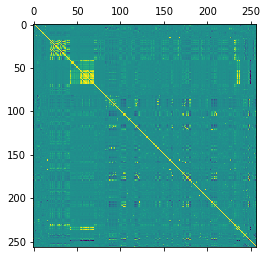

In [68]:
X_train = full_train.drop(columns=['AdoptionSpeed'])
y_train = full_train['AdoptionSpeed']
X_test = full_test.copy()

# X_train.to_csv("./train_X.pkl")
# X_test.to_csv("./test_X.pkl")
# y_train.to_csv("./train_y.pkl")

print(X_train.shape, X_test.shape)

plt.matshow(X_train.corr())
plt.show()

# PART 2. Add features from images

In [69]:
path_to_features_train = '../input/features-from-images/'
X_features_train = np.load(path_to_features_train + 'X_features_resnet101.npy')
X_img_names_train = np.load(path_to_features_train + 'X_img_names.npy')
X_img_names_train = [name.replace('../input/petfinder-adoption-prediction/train_images/','').replace('-1.jpg', '')
                    for name in X_img_names_train]

path_to_features_test = '../input/test-features-from-images/'
X_features_test = np.load(path_to_features_test + 'X_features_resnet101test.npy')
X_img_names_test = np.load(path_to_features_test + 'X_img_names_resnet101test.npy')
X_img_names_test = [name.replace('../input/petfinder-adoption-prediction/test_images/','').replace('-1.jpg', '')
                    for name in X_img_names_test]

df_img_features_train = pd.DataFrame(data=X_features_train, index=X_img_names_train)
df_img_features_test = pd.DataFrame(data=X_features_test, index=X_img_names_test)

df_img_features_train.head(2)



#### merge t#### merge the image features with the main datasethe image features with the main dataset
filler_img_feature_for_nan = df_img_features_train.append(df_img_features_test).mean()

X_train = pd.merge(X_train, df_img_features_train, left_index = True, right_index = True, how='left')
X_test  = pd.merge(X_test,  df_img_features_test,  left_index = True, right_index = True, how='left')

for feature_col in range(X_features_test.shape[1]):
    X_train[feature_col].fillna(filler_img_feature_for_nan[feature_col], inplace=True)
    X_test[feature_col].fillna(filler_img_feature_for_nan[feature_col], inplace=True)
    
X_train.head(2)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PhotoAmt,document_magnitude,document_score,sentences_magnitude_count,sentences_magnitude_mean,sentences_magnitude_std,sentences_magnitude_min,sentences_magnitude_25%,sentences_magnitude_50%,sentences_magnitude_75%,sentences_magnitude_max,sentences_score_count,sentences_score_mean,sentences_score_std,sentences_score_min,sentences_score_25%,sentences_score_50%,sentences_score_75%,sentences_score_max,ORGANIZATION,OTHER,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
86e1089a3,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,2932,0,1.0,2.4,0.3,6.0,0.366667,0.350238,0.0,0.125,0.25,0.675,0.8,6.0,0.30,0.419524,-0.2,0.025,0.20,0.675,0.8,1.0,8.0,...,0.139400,0.301738,0.669857,0.342531,0.234026,0.231610,0.837159,0.808509,0.166831,0.302242,0.524660,0.620502,0.380866,0.220654,0.697768,0.303097,0.322347,0.231219,1.005948,0.664983,0.673526,0.500041,0.274847,0.461143,1.026638,0.727895,0.257359,0.968704,0.343794,0.199879,0.260376,0.998662,0.269467,0.565174,0.568633,0.766147,0.358999,0.529338,0.517751,0.086800
6296e909a,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,1113,0,2.0,0.7,-0.2,2.0,0.350000,0.353553,0.1,0.225,0.35,0.475,0.6,2.0,-0.25,0.494975,-0.6,-0.425,-0.25,-0.075,0.1,0.0,1.0,...,0.439434,0.352646,0.846303,0.273696,0.183243,0.258251,0.674954,0.574795,0.548711,0.339606,1.189308,0.483307,0.537349,0.290466,0.321986,0.963685,0.418317,0.080001,0.600338,0.554814,0.716642,0.538577,0.160876,1.125162,0.844871,0.655485,0.248431,1.172226,0.304852,0.414468,0.627839,0.877818,0.608828,0.619814,0.398594,0.387345,0.105290,0.806921,1.060048,0.490804


# Part 3. Model training:

In competition we need to use quadratic weighted kappa. For this we took a Python code from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py

In [70]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

In [71]:
import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights = 'quadratic')
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

### CV SCORE WITH NON_TUNED LGBM

In [72]:
# kappa_scorer = make_scorer(quadratic_weighted_kappa)
# kf = model_selection.KFold(n_splits = 5, random_state = 42, shuffle = True)
# model = lgb.LGBMRegressor(n_jobs=-1, random_state=42, n_estimators=10, reg_alpha=1.3, reg_lambda=1.3)
# scores = model_selection.cross_val_score(model, X_train, y_train, cv=kf, n_jobs=-1, scoring = kappa_scorer, verbose=100)
# scores

In [73]:
def neg_quadratic_weighted_kappa(pred, true):
    return -quadratic_weighted_kappa(pred, true)

qwk_scorer = make_scorer(neg_quadratic_weighted_kappa, greater_is_better=False)

In [74]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'n_estimators': int(params['n_estimators']),
        'min_child_samples': int(params['min_child_samples']),
        'learning_rate': '{:.5f}'.format(params['learning_rate']),
        #'feature_fraction': '{:.5f}'.format(params['feature_fraction']),
        #'bagging_fraction': '{:.5f}'.format(params['bagging_fraction']),
        'min_gain_to_split': '{:.5f}'.format(params['min_gain_to_split']),
    }
    
    clf = lgb.LGBMRegressor(
        n_jobs=-1, random_state=42,
        **params
    )
    
    score = model_selection.cross_val_score(clf, X_train, y_train, scoring=qwk_scorer, cv=StratifiedKFold(n_splits=3)).mean()
    print("QWK {:.5f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'n_estimators': hp.quniform('n_estimators', 500, 2500, 2),
    'min_child_samples': hp.quniform('min_child_samples', 30, 200, 2),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    #'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9),
    #'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 0.9),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.0, 0.5),
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=10)
pickle.dump(trials, open("hyperopt_params.p", "wb"))
print("Otimal paramaters: {}".format(best))

QWK 0.29206 params {'num_leaves': 40, 'n_estimators': 2056, 'min_child_samples': 88, 'learning_rate': '0.01996', 'min_gain_to_split': '0.29680'}
QWK 0.28105 params {'num_leaves': 66, 'n_estimators': 982, 'min_child_samples': 108, 'learning_rate': '0.13411', 'min_gain_to_split': '0.03566'}
QWK 0.28801 params {'num_leaves': 66, 'n_estimators': 1398, 'min_child_samples': 148, 'learning_rate': '0.09499', 'min_gain_to_split': '0.14026'}
QWK 0.28918 params {'num_leaves': 66, 'n_estimators': 2448, 'min_child_samples': 174, 'learning_rate': '0.05658', 'min_gain_to_split': '0.20807'}
QWK 0.27559 params {'num_leaves': 94, 'n_estimators': 1070, 'min_child_samples': 38, 'learning_rate': '0.13404', 'min_gain_to_split': '0.39390'}
QWK 0.28165 params {'num_leaves': 68, 'n_estimators': 934, 'min_child_samples': 78, 'learning_rate': '0.11129', 'min_gain_to_split': '0.39485'}
QWK 0.29196 params {'num_leaves': 16, 'n_estimators': 2390, 'min_child_samples': 96, 'learning_rate': '0.05997', 'min_gain_to_spl

In [75]:
trials = pickle.load(open("hyperopt_params.p", "rb"))
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=10)
pickle.dump(trials, open("hyperopt_params.p", "wb"))
print("Otimal paramaters: {}".format(best))

0it [00:00, ?it/s, best loss: ?]
Otimal paramaters: {'learning_rate': 0.16736308082988877, 'min_child_samples': 72.0, 'min_gain_to_split': 0.270240324215537, 'n_estimators': 1406.0, 'num_leaves': 118.0}


In [76]:
trials = pickle.load(open("hyperopt_params.p", "rb"))
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=10)
pickle.dump(trials, open("hyperopt_params.p", "wb"))
print("Otimal paramaters: {}".format(best))

0it [00:00, ?it/s, best loss: ?]
Otimal paramaters: {'learning_rate': 0.16736308082988877, 'min_child_samples': 72.0, 'min_gain_to_split': 0.270240324215537, 'n_estimators': 1406.0, 'num_leaves': 118.0}


In [77]:
trials = pickle.load(open("hyperopt_params.p", "rb"))
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=10)
pickle.dump(trials, open("hyperopt_params.p", "wb"))
print("Otimal paramaters: {}".format(best))

0it [00:00, ?it/s, best loss: ?]
Otimal paramaters: {'learning_rate': 0.16736308082988877, 'min_child_samples': 72.0, 'min_gain_to_split': 0.270240324215537, 'n_estimators': 1406.0, 'num_leaves': 118.0}


In [78]:
trials = pickle.load(open("hyperopt_params.p", "rb"))
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=10)
pickle.dump(trials, open("hyperopt_params.p", "wb"))
print("Otimal paramaters: {}".format(best))

0it [00:00, ?it/s, best loss: ?]
Otimal paramaters: {'learning_rate': 0.16736308082988877, 'min_child_samples': 72.0, 'min_gain_to_split': 0.270240324215537, 'n_estimators': 1406.0, 'num_leaves': 118.0}


In [79]:
### import lightgbm as lgb

params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 15, # 9
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17}

# Additional parameters:
early_stop = 300
verbose_eval = 300
num_rounds = 10000
n_splits = 5

In [80]:
kfold = KFold(n_splits=n_splits, random_state=42, shuffle=True)


oof_train = np.zeros((X_train.shape[0]))
oof_test = np.zeros((X_test.shape[0], n_splits))


i = 0
for train_index, valid_index in kfold.split(X_train, y_train):
    
    X_tr = X_train.iloc[train_index]
    X_val = X_train.iloc[valid_index]
    
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[valid_index]
    
    print('\ny_tr distribution: {}'.format(Counter(y_tr)))
    
    d_train = lgb.Dataset(X_tr, label=y_tr)
    d_valid = lgb.Dataset(X_val, label=y_val)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    #model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    oof_train[valid_index] = val_pred
    oof_test[:, i] = test_pred
    
    i += 1

IndentationError: unexpected indent (<ipython-input-80-0ad9e8da8311>, line 25)

In [81]:
plt.hist(oof_train)

NameError: name 'oof_train' is not defined

In [82]:
# Compute QWK based on OOF train predictions:
optR = OptimizedRounder()
optR.fit(oof_train, y_train)
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train, coefficients)
print("\nValid Counts = ", Counter(y_train.values))
print("Predicted Counts = ", Counter(pred_test_y_k))
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(y_train.values, pred_test_y_k)
print("QWK = ", qwk)

NameError: name 'oof_train' is not defined

In [83]:
# Manually adjusted coefficients:

coefficients_ = coefficients.copy()

coefficients_[0] = 1.645
coefficients_[1] = 2.115
coefficients_[3] = 2.84

train_predictions = optR.predict(oof_train, coefficients_).astype(int)
print('train pred distribution: {}'.format(Counter(train_predictions)))

test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_)
print('test pred distribution: {}'.format(Counter(test_predictions)))

NameError: name 'coefficients' is not defined

In [84]:
# Distribution inspection of original target and predicted train and test:

print("True Distribution:")
print(pd.value_counts(y_train, normalize=True).sort_index())
print("\nTrain Predicted Distribution:")
print(pd.value_counts(train_predictions, normalize=True).sort_index())
print("\nTest Predicted Distribution:")
print(pd.value_counts(test_predictions, normalize=True).sort_index())

True Distribution:
0    0.027346
1    0.206096
2    0.269259
3    0.217368
4    0.279931
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:


NameError: name 'train_predictions' is not defined

In [85]:
# Generate submission:

submission = pd.DataFrame({'PetID': X_test.index, 'AdoptionSpeed': test_predictions.astype(np.int32)})
submission.head()
submission.to_csv('submission.csv', index=False)

NameError: name 'test_predictions' is not defined

In [86]:
# def soft_kappa_grad_hess(preds, dtrain):
#     '''
#         Returns first and second derivatives of the objective with respect to predictions `p`. 
#         `y` is a vector of corresponding target labels.  
#     '''
# #     y = dtrain.get_label() + 1
#     y = dtrain + 1
#     M = preds.shape[0]
#     N = preds.shape[1]
    
#     norm = np.linalg.norm(preds)**2 + np.linalg.norm(y)**2
    
#     grad = (- 2 * y.reshape(-1,1) / norm * np.ones(preds.shape) + 
#             4 * preds * np.dot(y, preds) / (norm ** 2))
#     hess = (8 * preds * y.reshape(-1,1) *  np.ones(preds.shape) / (norm ** 2) + 4 * np.dot(y, preds) / (norm ** 2)  - 
#             (16 * preds ** 2 * np.dot(y, preds)) / (norm ** 3))
#     return grad.reshape(M*N), hess.reshape(M*N)

# def soft_kappa(preds, dtrain):
#     '''
#         Having predictions `preds` and targets `dtrain.get_label()` this function coumputes soft kappa loss.
#         NOTE, that it assumes `mean(target) = 0`.
        
#     '''
# #     y = dtrain.get_label() + 1
#     y = dtrain + 1
#     norm = np.linalg.norm(preds)**2 + np.linalg.norm(y)**2
#     preds = np.argmax(preds, axis=1) + 1
#     return 'kappa', -2 * y.dot(preds) / norm

In [87]:
# y = np.array([1,2,2,0])
# p = np.array([[0.8, 0.3, 0.6],[0.4, 0.1, 0.8],[0., 0.5, 0.7],[0.67, 0.5, 0.5]])

In [88]:
# soft_kappa_grad_hess(p,y), soft_kappa(p,y)

In [89]:

# import numpy as np
# def softmax(score):
#     score = np.asarray(score, dtype=float)
#     score = np.exp(score-np.max(score))
#     score /= np.sum(score, axis=1)[:,np.newaxis]
#     return score

# ## soft version of kappa score using the class probability
# ## inspired by @George Mohler in the Higgs competition
# ## https://www.kaggle.com/c/higgs-boson/forums/t/10286/customize-loss-function-in-xgboost/53459#post53459
# ## NOTE: As also discussed in the above link, it is hard to tune the hessian to get it to work.
# def softkappaobj(preds, dtrain):
#     ## label are in [0,1,2,3] as required by XGBoost for multi-classification
#     labels = dtrain.get_label() + 1
#     labels = np.asarray(labels, dtype=int)
#     preds = softmax(preds)
#     M = preds.shape[0]
#     N = preds.shape[1]

#     ## compute O (enumerator)
#     O = 0.0
#     for j in range(N):
#         wj = (labels - (j+1.))**2
#         O += np.sum(wj * preds[:,j])
    
#     ## compute E (denominator)
#     hist_label = np.bincount(labels)[1:]
#     hist_pred = np.sum(preds, axis=0)
#     E = 0.0
#     for i in range(N):
#         for j in range(N):
#             E += pow(i - j, 2.0) * hist_label[i] * hist_pred[j]

#     ## compute gradient and hessian
#     grad = np.zeros((M, N))
#     hess = np.zeros((M, N))
#     for n in range(N):
#         ## first-order derivative: dO / dy_mn
#         dO = np.zeros((M))
#         for j in range(N):
#             indicator = float(n == j)
#             dO += ((labels - (j+1.))**2) * preds[:,n] * (indicator - preds[:,j])
#         ## first-order derivative: dE / dy_mn
#         dE = np.zeros((M))
#         for k in range(N):
#             for l in range(N):
#                 indicator = float(n == k)
#                 dE += pow(k-l, 2.0) * hist_label[l] * preds[:,n] * (indicator - preds[:,k])
#         ## the grad
#         grad[:,n] = -M * (dO * E - O * dE) / (E**2)
        
#         ## second-order derivative: d^2O / d (y_mn)^2
#         d2O = np.zeros((M))
#         for j in range(N):
#             indicator = float(n == j)
#             d2O += ((labels - (j+1.))**2) * preds[:,n] * (1 - 2.*preds[:,n]) * (indicator - preds[:,j])
       
#         ## second-order derivative: d^2E / d (y_mn)^2
#         d2E = np.zeros((M))
#         for k in range(N):
#             for l in range(N):
#                 indicator = float(n == k)
#                 d2E += pow(k-l, 2.0) * hist_label[l] * preds[:,n] * (1 - 2.*preds[:,n]) * (indicator - preds[:,k])
#         ## the hess
#         hess[:,n] = -M * ((d2O * E - O * d2E)*(E**2) - (dO * E - O * dE) * 2. * E * dE) / (E**4)

#     grad *= -1.
#     hess *= -1.
#     # this pure hess doesn't work in my case, but the following works ok
#     # use a const
#     #hess = 0.000125 * np.ones(grad.shape, dtype=float)
#     # or use the following...
#     scale = 0.000125 / np.mean(abs(hess))
#     hess *= scale
#     hess = np.abs(hess) # It works!! no idea...
# #     grad.shape = (M*N)
# #     hess.shape = (M*N)
#     return grad.shape, hess.shape

# # evalerror is your customized evaluation function to 
# # 1) decode the class probability 
# # 2) compute quadratic weighted kappa
# def evalerror(preds, dtrain):
#     ## label are in [0,1,2,3] as required by XGBoost for multi-classification
#     labels = dtrain.get_label() + 1
#     ## class probability
#     preds = softmax(preds)
#     ## decoding (naive argmax decoding)
#     pred_labels = np.argmax(preds, axis=1) + 1
#     ## compute quadratic weighted kappa (using implementation from @Ben Hamner
#     ## https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py
#     kappa = quadratic_weighted_kappa(labels, pred_labels)
#     return 'kappa', kappa

In [90]:
# from sklearn.model_selection import train_test_split
# import xgboost as xgb
# ####################
# ## Model buliding ##
# ####################
# ## to use the above obj, you have to use the following task param (in addition to your general param and booster param)
# ## see https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
# param = {
#     'objective': 'reg:linear', # for linear raw predict score
#     'num_class': 5 # num of classes
# }

# param['booster'] = 'gblinear'
# param['eta'] = 1
# param['lambda'] = 0.00005
# param['alpha'] = 0.000001

# ## data

# X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, shuffle=True, random_state=42)
# dtrain = xgb.DMatrix(X_tr, y_tr)
# dvalid = xgb.DMatrix(X_val, y_val)

# ## train
# num_round = 10
# watchlist = [(dtrain, 'train'), (dvalid, "valid")]
# bst = xgb.train(param, dtrain, num_round, watchlist, obj=softkappaobj, feval=evalerror)

# ## make prediction (class probability)
# pred = softmax(bst.predict(dvalid))

In [91]:
# dtrain = xgb.DMatrix(X_tr, label = y_tr)
# dvalid = xgb.DMatrix(X_val, label = y_val)

In [92]:
# a,b,c,d = train_test_split(X_train, y_train, shuffle=True, random_state=42)

In [93]:
# a.info()